In [1]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from imgaug import augmenters as iaa
import custom_augmentation as ciaa
import random

In [2]:
labels_file = json.loads(open('label_sign.json','r').read())
print('Numbers of sample:', len(labels_file))

Numbers of sample: 6691


Tạo và kiểm tra path cho các ảnh trong dataset thuii.

In [3]:
for index, each_sample in tqdm(enumerate(labels_file), desc='Creating full path', total=len(labels_file)):
#     rgb_img_path = os.path.join(dataset_path, 'rgb', '{}_rgb.jpg'.format(each_sample['index']))
    each_sample['path'] = each_sample['path'].replace('./model_notTrashCar/','./')
    if not os.path.isfile(each_sample['path']):
        print(rgb_img_path, 'not exist. Skipped')
        labels_file.remove(each_sample)

Creating full path: 100%|██████████| 6691/6691 [00:00<00:00, 401133.30it/s]


In [4]:
labels_file

[{'path': './traffic_sign/rgb_4693_3.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_2625_0.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_2344_2.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_9082_0.jpg', 'sign': 'right'},
 {'path': './traffic_sign/rgb_2355_0.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_2850_0.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_6563_5.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_6738_1.jpg', 'sign': 'right'},
 {'path': './traffic_sign/rgb_4683_11.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_6749_0.jpg', 'sign': 'right'},
 {'path': './traffic_sign/rgb_4686_1.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_6712_2.jpg', 'sign': 'right'},
 {'path': './traffic_sign/rgb_6598_0.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_6535_0.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_4693_10.jpg', 'sign': 'None'},
 {'path': './traffic_sign/rgb_6747_0.jpg', 'sign': 'right'},
 {'path': './traffic_sign/rgb_655

Augment để còn upsampling nhé

In [5]:
def show_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [6]:
augment_object = iaa.Sequential([
    iaa.Add((-20, 20)),
    iaa.Sometimes(0.1, iaa.AdditiveGaussianNoise(scale=0.03*255)),
    iaa.Sometimes(0.2, iaa.MotionBlur(angle=(0, 360))),
    iaa.Sometimes(0.1, iaa.GammaContrast(gamma=(0.5, 1.44))),
])

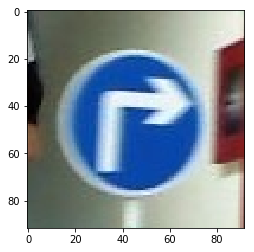

In [7]:
test_img = cv2.imread(random.choice(labels_file)['path'])
show_img(test_img)

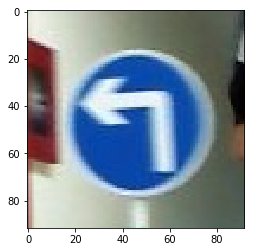

In [8]:
test_img_flip = cv2.flip(test_img, 1)
show_img(test_img_flip)

Upsampling để cân distribution giữa các angle

In [9]:
def calculate_amount():
    global left, right, none
    left = right = none = 0
    for each_sample in labels_file:
        if each_sample['sign'] == 'left':
            left += 1
        elif each_sample['sign'] == 'right':
            right += 1
        else:
            none += 1
    print('Left: {} Right: {} None: {}'.format(left, right, none))
calculate_amount()

Left: 415 Right: 1526 None: 4750


In [10]:
none/left

11.44578313253012

In [11]:
none/right

3.112712975098296

In [12]:
def augment_duplicate_upsampling(dataset, src_amount, dst_amount, sign_type):
    new_sample_list = []
    if dst_amount/src_amount < 2:
        percent_need_upsample = int(((dst_amount-src_amount)/2)/src_amount * 100)
        multiplier = 1
    else:
        percent_need_upsample = 101
        multiplier = (dst_amount // src_amount) - 1
    for index, each_sample in tqdm(enumerate(dataset), total=len(dataset)):
        if each_sample['sign'] == sign_type and random.randint(0, 100) <= percent_need_upsample:
            old_path = each_sample['path']
            org_img = cv2.imread(old_path)
            for output_index in range(multiplier):
                new_path = old_path.replace('.jpg','_{}.jpg'.format(output_index))
                new_img = augment_object.augment_image(org_img)
                cv2.imwrite(new_path, new_img)
                new_sample = {
                    'path': new_path,
                    'sign': each_sample['sign']
                }
                new_sample_list.append(new_sample)
    final_data = new_sample_list + dataset
    print("Numbers of sample after upsampling: ", len(final_data))
    return final_data

In [13]:
def augment_flip_image(dataset, src_amount, dst_amount, sign_type):
    new_sample_list = []
    if dst_amount/src_amount < 2:
        percent_need_upsample = int(((dst_amount-src_amount)/2)/src_amount * 100)
        multiplier = 1
    else:
        percent_need_upsample = 101
        multiplier = (dst_amount // src_amount) - 1
    for index, each_sample in tqdm(enumerate(dataset), total=len(dataset)):
        if each_sample['sign'] == sign_type and each_sample['sign'] != 'None' and random.randint(0, 100) <= percent_need_upsample:
            for output_index in range(multiplier):
                old_rgb_path = each_sample['path']
                org_rgb_img = cv2.imread(old_rgb_path)            
                new_rgb_img = cv2.flip(org_rgb_img, 1)
                new_rgb_path = old_rgb_path.replace('.jpg','_{}.jpg'.format(output_index))
                cv2.imwrite(new_rgb_path, new_rgb_img)
                new_sign_type = 'left' if sign_type == 'right' else 'right'
                new_sample = {
                    'path': new_rgb_path,
                    'sign': new_sign_type
                }
                new_sample_list.append(new_sample)
    final_data = new_sample_list + dataset
    print("Numbers of sample after upsampling: ", len(final_data))
    return final_data 

In [14]:
labels_file = augment_flip_image(labels_file, left, right, 'right')
calculate_amount()

100%|██████████| 6691/6691 [00:00<00:00, 8020.65it/s]

Numbers of sample after upsampling:  9743
Left: 3467 Right: 1526 None: 4750


In [15]:
labels_file = augment_duplicate_upsampling(labels_file, left, none, 'left')
calculate_amount()

100%|██████████| 9743/9743 [00:00<00:00, 20442.93it/s]

Numbers of sample after upsampling:  10372
Left: 4096 Right: 1526 None: 4750


In [16]:
labels_file = augment_duplicate_upsampling(labels_file, right, none, 'right')
calculate_amount()

100%|██████████| 10372/10372 [00:02<00:00, 5023.46it/s]

Numbers of sample after upsampling:  13424
Left: 4096 Right: 4578 None: 4750


In [17]:
with open('./over_sampled_label.json', 'w', encoding='utf-8') as outfile:
    json.dump(labels_file, outfile, ensure_ascii=False, sort_keys=False, indent=4)
    outfile.write("\n")